Imports

In [11]:

# Built-in libraries
import os
import time
import urllib.request
from io import BytesIO

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import random
import shutil
import glob
import requests

# TensorFlow and Keras related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    Activation,
    PReLU,
    BatchNormalization,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

# Web scraping libraries
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from random import randint
from PIL import Image



# Introduction
        In this project, I have downloaded images of five different animals, each in shape 128 x 128, and built a Convolutional Neural Network (CNN) model to classify these animals. The five animals that were included in the dataset are cats, dogs, horses, elephants, and lions. The dataset was obtained from various online sources and was preprocessed to ensure that all images were in the same size and format.

        The CNN model was constructed using the TensorFlow and Keras libraries in Python. The model consists of several layers of convolution, pooling, and fully connected layers, with appropriate activation functions and regularization techniques to prevent overfitting. The model was trained on a subset of the dataset and then evaluated on a separate validation set to ensure that the model generalizes well to unseen data.

        The ultimate goal of this project is to accurately classify new images of these five animals based on the learned patterns from the training data. This can have various applications, such as identifying animals in wildlife images or in a veterinary clinic setting.
    
# About Data
        The dataset used in this study consisted of images of five different animal species, namely chimpanzees, lions, armadillos, jellyfish, and tigers. Initially, attempts were made to scrape images from Google to expand the dataset. However, due to safety restrictions, only a limited number of images could be downloaded without access to the Google API. Furthermore, the images were of variable sizes and shapes, which made it challenging to preprocess the data without introducing distortions. In addition to the challenges mentioned above, another issue was identified during the preprocessing stage. It was discovered that some images were duplicated, and one of them could be used in training while the other was used in validation, which could skew the metrics.

        To overcome these challenges, a dataset of animal images was obtained from https://images.cv/. This website provided a comprehensive collection of animal images that were preprocessed and augmented in various ways, such as reshaping and applying augmentation techniques like flipping, mixing random pixels, and applying random contrast.

        The dataset consisted of a total of 2500 images, with 500 images per animal species. The images were preprocessed to ensure that they were of the same size and format before being used for model training and evaluation.

In [79]:
# Define the class subdirectories in the source and destination directories
class_subdirs = ['chimpanzee', 'lion', 'armadillo', 'jellyfish', 'tiger']
image_folder = 'animal-images2'
train_dir = 'animal-images2/train_dir'
val_dir = 'animal-images2/val_dir'
test_dir = 'test_dir'

# Images Sample

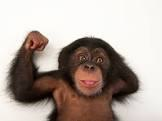

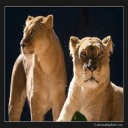

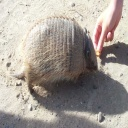

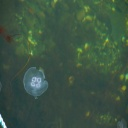

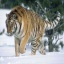

In [82]:
from PIL import Image
from IPython.display import display


# Load and display one image from each folder
for subdir in class_subdirs:
    img_path = os.path.join(train_dir, subdir, os.listdir(os.path.join(train_dir, subdir))[0])
    img = Image.open(img_path)
    display(img)


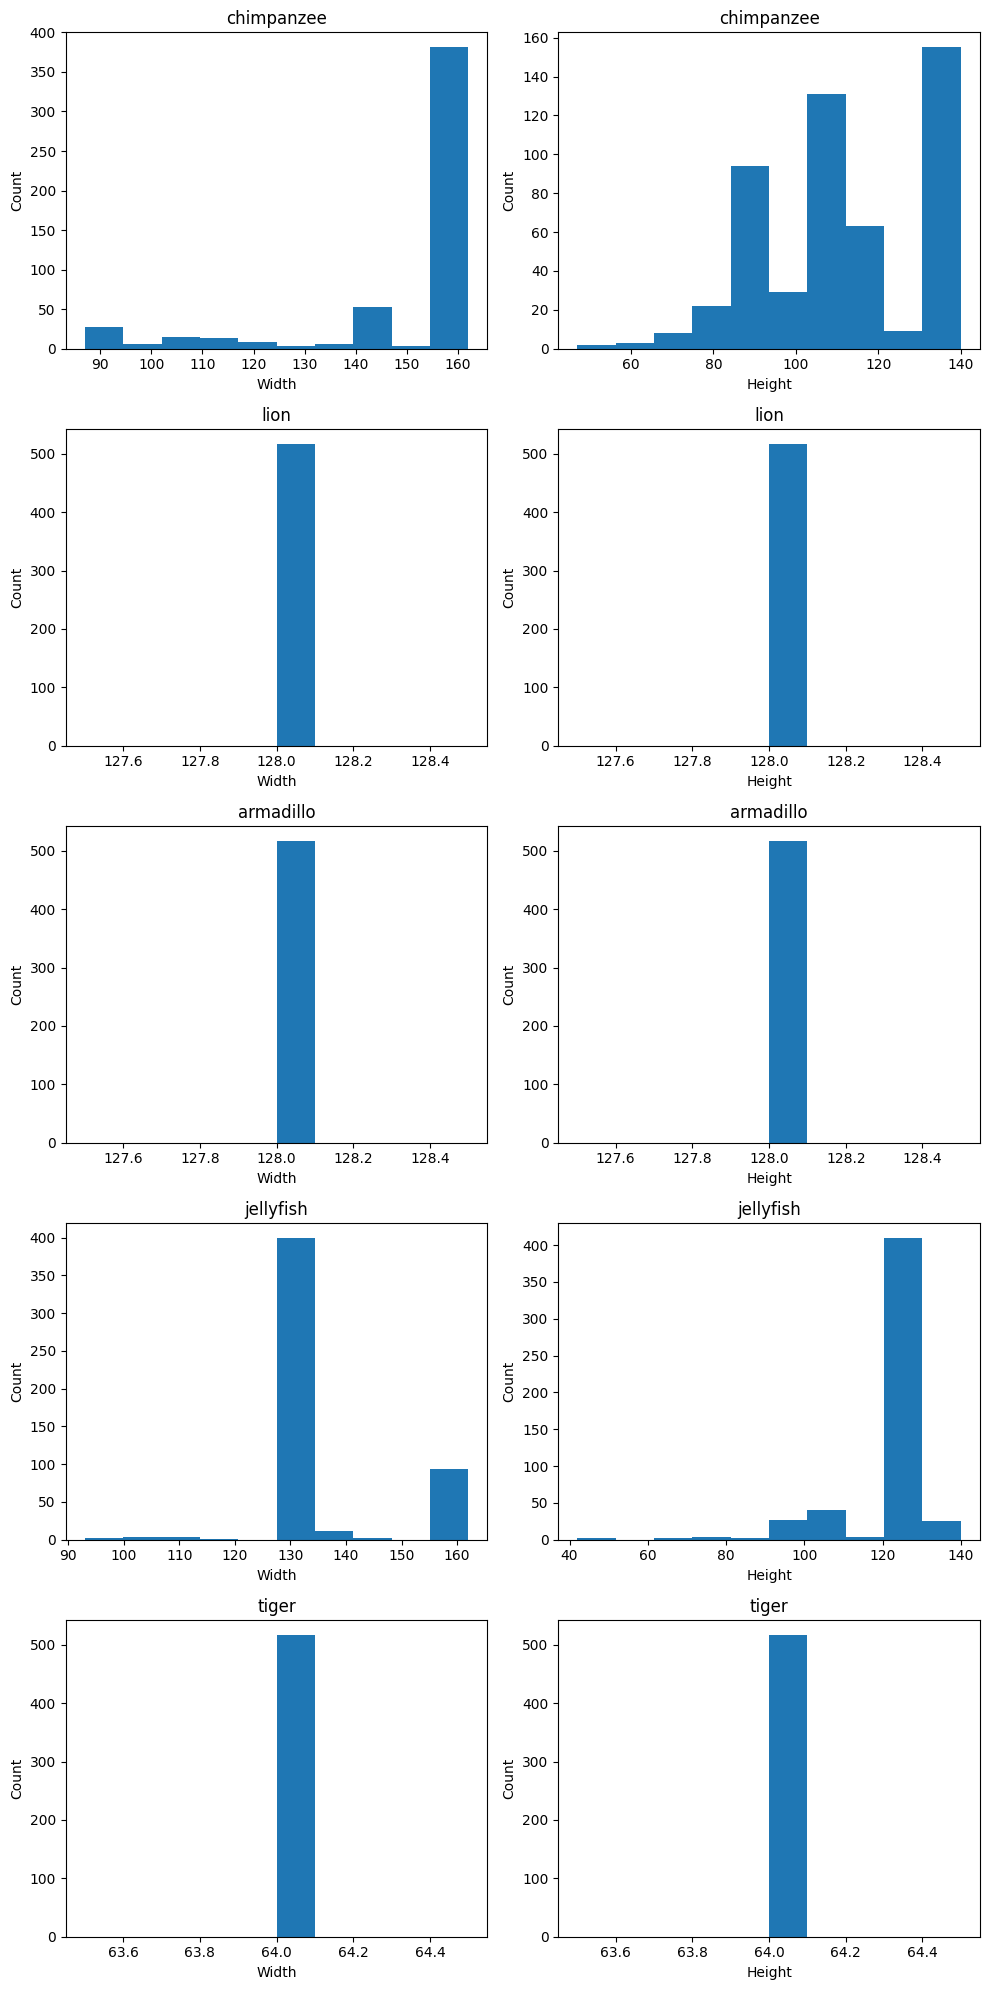

In [92]:
widths = []
heights = []

for subdir in class_subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    subdir_images = os.listdir(subdir_path)
    
    subdir_widths = []
    subdir_heights = []
    
    for img_name in subdir_images:
        img_path = os.path.join(subdir_path, img_name)
        img = Image.open(img_path)
        width, height = img.size
        subdir_widths.append(width)
        subdir_heights.append(height)
    
    widths.append(subdir_widths)
    heights.append(subdir_heights)

# Plot histograms of widths and heights for each subdir
fig, ax = plt.subplots(nrows=len(class_subdirs), ncols=2, figsize=(10, 4*len(class_subdirs)))

for i, subdir in enumerate(class_subdirs):
    ax[i,0].hist(widths[i])
    ax[i,0].set_xlabel('Width')
    ax[i,0].set_ylabel('Count')
    ax[i,0].set_title(subdir)
    
    ax[i,1].hist(heights[i])
    ax[i,1].set_xlabel('Height')
    ax[i,1].set_ylabel('Count')
    ax[i,1].set_title(subdir)

plt.tight_layout()
plt.show()

In [14]:
# Function to download an image from a given URL

def download_image(url):
    """
    Function to download an image from a given URL.

    This function uses the 'requests' library to download an image from a specified URL.
    It checks that the response is valid and returns the image response.

    Parameters:
    url (str): The URL of the image to download.

    Returns:
    response (requests.Response): The response object containing the downloaded image.
    """
    response = requests.get(url, stream=True)
    response.raise_for_status()
    return response

# Function to resize the image
def resize_image(image_data, size):
    img = Image.open(image_data)
    return img

# Add the function to generate Google Images search URLs
def search_google_images(query, start):
    query = query.replace(' ', '+')
    return f'https://www.google.com/search?q={query}&tbm=isch&start={start}'

# Modify the scrape_images function to use the Google Images search URL and class_subdirs
def scrape_images(class_subdirs, download_folder, num_images_per_class=200):
    """
    Function to scrape animal images from Google Images and download them to a specified directory.

    This function takes a list of animal subdirectories and scrapes Google Images for each class.
    The images are then downloaded and saved to the specified download directory. The function uses
    the 'requests' and 'BeautifulSoup' libraries to search and download the images.

    Parameters:
    class_subdirs (list): A list of animal subdirectories to search and download images for.
    download_folder (str): The path to the directory where the downloaded images will be saved.
    num_images_per_class (int): The number of images to download per class.

    Returns:
    None
    """
    for subdir in class_subdirs:
        # Create a subfolder for each class
        subdir_path = os.path.join(download_folder, subdir)
        if not os.path.exists(subdir_path):
            os.makedirs(subdir_path)

        images_downloaded = 0
        start = 0

        while images_downloaded < num_images_per_class:
            # Get the Google Images search URL for the current animal
            search_url = search_google_images(subdir, start)
            time.sleep(randint(1, 3))
            response = requests.get(search_url)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find all image tags in the webpage
            img_tags = soup.find_all('img')

            # Iterate through image tags and download the images
            for idx, img in enumerate(img_tags):
                if images_downloaded >= num_images_per_class:
                    break

                img_url = img.get('src')

                if img_url:
                    if img_url.startswith('//'):
                        img_url = 'http:' + img_url

                    if not img_url.startswith('http'):
                        continue

                    print(f'Downloading image {idx} for {subdir} from {img_url}')
                    try:
                        response = download_image(img_url)
                        resized_img = resize_image(response.raw, (256, 256))
                        save_path = os.path.join(subdir_path, f'image_{images_downloaded}.jpg')
                        resized_img.save(save_path)
                        images_downloaded += 1
                    except (requests.exceptions.RequestException, IOError) as e:
                        print(f'Failed to download and resize {img_url}: {e}')

            start += 20

    # Define the source and destination directories
image_folder = 'animal-images2'
train_dir = os.path.join(image_folder, 'train_dir')
val_dir = os.path.join(image_folder, 'val_dir')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


SCRAPE = 0
if SCRAPE==1:
# Scrape images for each class
    scrape_images(class_subdirs, test_dir, num_images_per_class=40)

        The data was split into training and validation sets using a custom function named split_data. This function selected an equal number of images from each class to ensure a balanced dataset. The selected images were randomly split into the training and validation sets, with 80% of the data used for training and 20% for validation. The training and validation directories were created for each class subdirectory, and the selected images were moved to their respective directories. The balanced dataset ensured that the model would learn to distinguish between each class of animal images effectively.

In [15]:

def split_data(class_subdirs):
    image_folder = 'animal-images2'
    train_dir = os.path.join(image_folder, 'train_dir')
    val_dir = os.path.join(image_folder, 'val_dir')
    # Define the train and validation split percentages
    train_split = 0.8
    val_split = 0.2
    class_subdirs = class_subdirs
    # Find the smallest number of images in any class
    min_images = float('inf')
    for subdir in class_subdirs:
        image_files = glob.glob(os.path.join(image_folder, subdir, '*.jpg'))
        min_images = min(min_images, len(image_files))

    # Loop through each class subdirectory
    for subdir in class_subdirs:
        # Get the list of image files in the current subdirectory
        image_files = glob.glob(os.path.join(image_folder, subdir, '*.jpg'))

        # Limit the number of images to the smallest number found
        image_files = random.sample(image_files, min_images)

        # Calculate the number of images to move to the train directory
        num_train_images = int(train_split * len(image_files))

        # Randomly select the images to move to the train directory
        train_images = random.sample(image_files, num_train_images)

        # Calculate the remaining images for the validation directory
        val_images = set(image_files) - set(train_images)

        # Randomly select the images to move to the validation directory
        val_images = random.sample(val_images, int(val_split * len(image_files)))

        # Create the class subdirectories in the train and validation directories if they don't already exist
        train_subdir = os.path.join(train_dir, subdir)
        val_subdir = os.path.join(val_dir, subdir)
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(val_subdir, exist_ok=True)

        # Move the selected images to the train directory
        for image_file in train_images:
            image_name = os.path.basename(image_file)
            train_image_path = os.path.join(train_subdir, image_name)
            shutil.copy(image_file, train_image_path)

        # Move the selected images to the validation directory
        for image_file in val_images:
            image_name = os.path.basename(image_file)
            val_image_path = os.path.join(val_subdir, image_name)
            shutil.copy(image_file, val_image_path)

split_data(class_subdirs)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_23136\2772984162.py:95: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_images = random.sample(val_images, int(val_split * len(image_files)))


        In order to further explore the capabilities of web scraping, an additional test dataset was obtained using the Python package BeautifulSoup. The dataset consists of images scraped from a Google search for the five animal species used in this study: chimpanzees, lions, armadillos, jellyfish, and tigers. By leveraging the power of web scraping, this additional dataset provides an opportunity to test the robustness and generalization of the trained models on new and unseen data. The prediction results on this test dataset will provide insight into the performance of the models when applied to real-world scenarios where access to labeled data may be limited.

In [20]:
datagen = ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory('animal-images2/train_dir',
                                        target_size=(96,96),
                                        batch_size=32,
                                        class_mode='categorical',
                                        classes=['chimpanzee', 'lion', 'armadillo', 'jellyfish', 'tiger'],
                                        color_mode='rgb')

val_gen = datagen.flow_from_directory('animal-images2/val_dir',
                                        target_size=(96,96),
                                        batch_size=32,
                                        class_mode='categorical',
                                        classes=['chimpanzee', 'lion', 'armadillo', 'jellyfish', 'tiger'],
                                        color_mode='rgb')

test_gen = datagen.flow_from_directory('test_dir',
                                        target_size=(96,96),
                                        batch_size=32,
                                        class_mode='categorical',
                                        classes=['chimpanzee', 'lion', 'armadillo', 'jellyfish', 'tiger'],
                                        color_mode='rgb')

Found 2580 images belonging to 5 classes.
Found 645 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


# Models

        The function get_basic_model1 defines a convolutional neural network (CNN) model for image classification. This model has several layers, including several convolutional layers, max pooling layers, and dense layers.

        The first layer is a Conv2D layer with 32 filters of size 3x3 and a PReLU activation function, followed by a BatchNormalization layer. This is repeated with another Conv2D layer with 32 filters of size 3x3, PReLU, and BatchNormalization, followed by a max pooling layer of size 2x2.

        Next, there are two sets of Conv2D layers with 64 filters of size 3x3, PReLU, and BatchNormalization, followed by another max pooling layer of size 2x2. After this, there are three sets of Conv2D layers with 128 filters of size 3x3, PReLU, and BatchNormalization, followed by another max pooling layer of size 2x2.

        The output of the convolutional layers is then flattened and passed through three dense layers with 512, 256, and 64 units, respectively. Each dense layer is followed by a PReLU, BatchNormalization, and Dropout layer with a dropout rate of 0.5 to prevent overfitting. The final dense layer has 5 units (one for each class) and uses the softmax activation function to output class probabilities.

        Model 2 is the same as Model 1, except that it uses a different learning rate for the Adam optimizer. Specifically, the learning rate is set to 0.001 instead of 0.01.

In [24]:
def get_basic_model1():
    
    model = Sequential(name = 'model1')

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3)))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(2):
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        model.add(BatchNormalization())
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(3):
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        model.add(BatchNormalization())
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dense(5, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model



In [25]:
model1 = get_basic_model1()
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 p_re_lu_30 (PReLU)          (None, 96, 96, 32)        294912    
                                                                 
 batch_normalization_30 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 p_re_lu_31 (PReLU)          (None, 94, 94, 32)        282752    
                                                                 
 batch_normalization_31 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                           

In [26]:
model1_history = model1.fit_generator(train_gen,
                        epochs = 30,
                        validation_data = val_gen)

Epoch 1/30


C:\Users\Pichau\AppData\Local\Temp\ipykernel_23136\2523238823.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1_history = model1.fit_generator(train_gen,


81/81 [==============================] - 34s 401ms/step - loss: 1.2350 - accuracy: 0.5105 - val_loss: 10.0260 - val_accuracy: 0.2109
Epoch 2/30
81/81 [==============================] - 28s 341ms/step - loss: 0.9817 - accuracy: 0.6143 - val_loss: 2.9684 - val_accuracy: 0.3380
Epoch 3/30
81/81 [==============================] - 28s 345ms/step - loss: 0.9075 - accuracy: 0.6364 - val_loss: 2.0693 - val_accuracy: 0.4264
Epoch 4/30
81/81 [==============================] - 28s 344ms/step - loss: 0.8394 - accuracy: 0.6655 - val_loss: 1.4389 - val_accuracy: 0.5225
Epoch 5/30
81/81 [==============================] - 28s 341ms/step - loss: 0.7966 - accuracy: 0.6806 - val_loss: 1.1767 - val_accuracy: 0.6093
Epoch 6/30
81/81 [==============================] - 28s 344ms/step - loss: 0.7489 - accuracy: 0.6988 - val_loss: 1.0114 - val_accuracy: 0.6837
Epoch 7/30
81/81 [==============================] - 28s 344ms/step - loss: 0.7068 - accuracy: 0.7233 - val_loss: 1.5302 - val_accuracy: 0.5132
Epoch 8/3

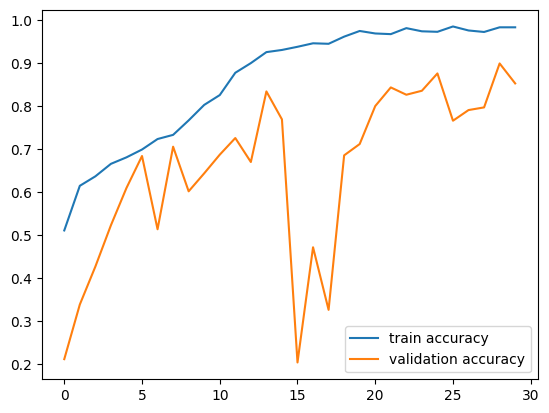

In [27]:
model1_history.history['val_accuracy']

plt.plot(model1_history.history['accuracy'], label="train accuracy" )
plt.plot(model1_history.history['val_accuracy'], label="validation accuracy")
plt.legend(loc='lower right')
plt.show()

In [28]:
def get_basic_model2():
    
    model = Sequential(name = 'model2')

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3)))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(2):
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        model.add(BatchNormalization())
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(3):
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        model.add(BatchNormalization())
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dense(5, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [29]:
model2 = get_basic_model2()
model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 p_re_lu_40 (PReLU)          (None, 96, 96, 32)        294912    
                                                                 
 batch_normalization_40 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 p_re_lu_41 (PReLU)          (None, 94, 94, 32)        282752    
                                                                 
 batch_normalization_41 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                           

In [30]:
model2_history = model2.fit_generator(train_gen,
                        epochs = 30,
                        validation_data = val_gen)

Epoch 1/30


C:\Users\Pichau\AppData\Local\Temp\ipykernel_23136\1576041801.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model2.fit_generator(train_gen,


81/81 [==============================] - 31s 350ms/step - loss: 1.1438 - accuracy: 0.5655 - val_loss: 3.4494 - val_accuracy: 0.2047
Epoch 2/30
81/81 [==============================] - 28s 345ms/step - loss: 0.8091 - accuracy: 0.6891 - val_loss: 1.8431 - val_accuracy: 0.3736
Epoch 3/30
81/81 [==============================] - 29s 355ms/step - loss: 0.6537 - accuracy: 0.7593 - val_loss: 2.8335 - val_accuracy: 0.2279
Epoch 4/30
81/81 [==============================] - 29s 354ms/step - loss: 0.5621 - accuracy: 0.7938 - val_loss: 1.5456 - val_accuracy: 0.4403
Epoch 5/30
81/81 [==============================] - 29s 353ms/step - loss: 0.4817 - accuracy: 0.8264 - val_loss: 2.2337 - val_accuracy: 0.5240
Epoch 6/30
81/81 [==============================] - 29s 360ms/step - loss: 0.4185 - accuracy: 0.8566 - val_loss: 0.7264 - val_accuracy: 0.7488
Epoch 7/30
81/81 [==============================] - 28s 345ms/step - loss: 0.3634 - accuracy: 0.8760 - val_loss: 1.1352 - val_accuracy: 0.7039
Epoch 8/30

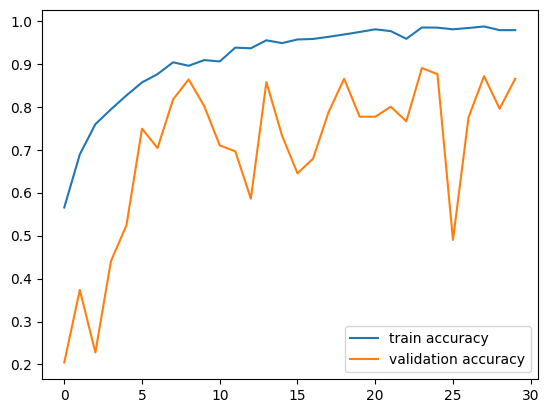

In [31]:
model2_history.history['val_accuracy']

plt.plot(model2_history.history['accuracy'], label="train accuracy" )
plt.plot(model2_history.history['val_accuracy'], label="validation accuracy")
plt.legend(loc='lower right')
plt.show()

In [32]:
def get_basic_model3():
    
    model = Sequential(name = 'model3')

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)))
    
    for i in range(3):
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(PReLU(alpha_initializer=Constant(value=0.25)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU(alpha_initializer=Constant(value=0.25)))
    model.add(BatchNormalization())
    
    model.add(Dense(5, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [33]:
model3 = get_basic_model3()
model3.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 96, 96, 128)       36992     
                                                                 
 p_re_lu_50 (PReLU)          (None, 96, 96, 128)       1179648   
                                                                 
 batch_normalization_50 (Bat  (None, 96, 96, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 128)       14758

In [35]:
model3_history = model3.fit_generator(train_gen,
                        epochs = 75,
                        validation_data = val_gen)

Epoch 1/75


C:\Users\Pichau\AppData\Local\Temp\ipykernel_23136\3309116721.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3_history = model3.fit_generator(train_gen,


81/81 [==============================] - 55s 683ms/step - loss: 0.0970 - accuracy: 0.9705 - val_loss: 0.3012 - val_accuracy: 0.9209
Epoch 2/75
81/81 [==============================] - 55s 679ms/step - loss: 0.1053 - accuracy: 0.9647 - val_loss: 0.3614 - val_accuracy: 0.8961
Epoch 3/75
81/81 [==============================] - 54s 668ms/step - loss: 0.1032 - accuracy: 0.9655 - val_loss: 0.3409 - val_accuracy: 0.8961
Epoch 4/75
81/81 [==============================] - 55s 680ms/step - loss: 0.1124 - accuracy: 0.9609 - val_loss: 0.3278 - val_accuracy: 0.8992
Epoch 5/75
81/81 [==============================] - 55s 679ms/step - loss: 0.1337 - accuracy: 0.9581 - val_loss: 0.3551 - val_accuracy: 0.8946
Epoch 6/75
81/81 [==============================] - 54s 667ms/step - loss: 0.1032 - accuracy: 0.9678 - val_loss: 0.3726 - val_accuracy: 0.8868
Epoch 7/75
81/81 [==============================] - 54s 670ms/step - loss: 0.1047 - accuracy: 0.9667 - val_loss: 0.4182 - val_accuracy: 0.8698
Epoch 8/75

81/81 [==============================] - 56s 688ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.3839 - val_accuracy: 0.8992
Epoch 59/75
81/81 [==============================] - 55s 674ms/step - loss: 0.0312 - accuracy: 0.9903 - val_loss: 0.3863 - val_accuracy: 0.9132
Epoch 60/75
81/81 [==============================] - 56s 690ms/step - loss: 0.0355 - accuracy: 0.9891 - val_loss: 0.4503 - val_accuracy: 0.9085
Epoch 61/75
81/81 [==============================] - 55s 685ms/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 0.3603 - val_accuracy: 0.9147
Epoch 62/75
81/81 [==============================] - 55s 680ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.3605 - val_accuracy: 0.9147
Epoch 63/75
81/81 [==============================] - 55s 678ms/step - loss: 0.0233 - accuracy: 0.9934 - val_loss: 0.3917 - val_accuracy: 0.9085
Epoch 64/75
81/81 [==============================] - 56s 687ms/step - loss: 0.0399 - accuracy: 0.9872 - val_loss: 0.3756 - val_accuracy: 0.9039
Epoc

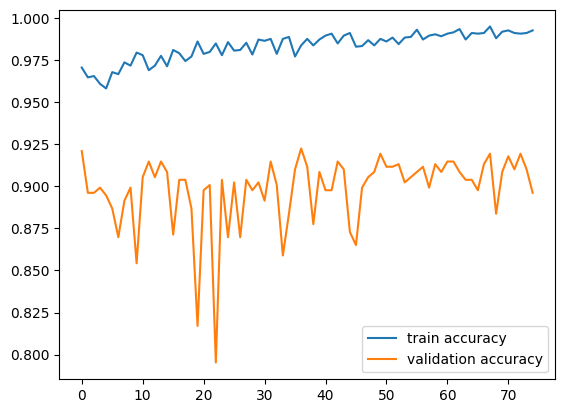

In [36]:
model3_history.history['val_accuracy']

plt.plot(model3_history.history['accuracy'], label="train accuracy" )
plt.plot(model3_history.history['val_accuracy'], label="validation accuracy")
plt.legend(loc='lower right')
plt.show()

In [38]:
model3.pred = model3.predict(test_gen)

7/7 [==============================] - 1s 164ms/step


In [39]:
model3.pred.shape

(200, 5)

# Results

        Upon evaluation, it was found that Model 1 had a high learning rate, resulting in unstable performance, as expected. This instability can have negative impacts on the accuracy and reliability of the model's predictions. Therefore, it is recommended to adjust the learning rate to a more appropriate level to achieve better results. It is also worth noting that the models do not seem to generalize well, as the test images used were of poor quality and had varying resolutions, which can skew the results. This can be attributed to the nature of Google images, which often feature white background pictures.

        It is important to mention that this is a baseline model and that there are now many other models available that can perform object detection, masking, and real-time analysis, among other applications. Some of these models are capable of predicting in a single forward propagation neural network, thereby improving performance and accuracy in specific scenarios.
        

In [89]:
df = pd.DataFrame(model3.pred, columns=[['chimpanzee', 'lion', 'armadillo', 'jellyfish', 'tiger']])
df = df.round(2)
df

,chimpanzee,lion,armadillo,jellyfish,tiger
0,0.46,0.0,0.53,0.00,0.00
1,0.00,0.0,0.00,1.00,0.00
2,0.00,1.0,0.00,0.00,0.00
3,0.00,0.0,0.00,1.00,0.00
4,1.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...
195,0.99,0.0,0.01,0.00,0.00
196,1.00,0.0,0.00,0.00,0.00
197,0.00,0.0,0.00,1.00,0.00
198,0.92,0.0,0.00,0.02,0.05


In [60]:
(df['armadillo']>0.5).value_counts()

(armadillo,)
False           180
True             20
Name: count, dtype: int64

In [61]:
(df['lion']>0.5).value_counts()

(lion,)
False      171
True        29
Name: count, dtype: int64

In [66]:
(df['chimpanzee']>0.5).value_counts()


(chimpanzee,)
False            124
True              76
Name: count, dtype: int64

In [67]:
(df['jellyfish']>0.5).value_counts()

(jellyfish,)
False           158
True             42
Name: count, dtype: int64

In [68]:
(df['tiger']>0.5).value_counts()

(tiger,)
False       170
True         30
Name: count, dtype: int64

In [65]:
max_cols = df.idxmax(axis=1)
print(max_cols.value_counts())

(chimpanzee,)    76
(jellyfish,)     43
(lion,)          31
(tiger,)         30
(armadillo,)     20
Name: count, dtype: int64
